In [71]:
import numpy as np
import pandas as pd
import os, os.path, shutil
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

from keras.models import Sequential
from keras.callbacks import EarlyStopping

from keras.layers import LSTM
from keras.layers import Dense

## RMES

In [72]:
def rmse(y, y_pred):
  return np.sqrt(((y - y_pred)**2).mean())

## 사인파 데이터 생성

In [19]:

def sine_data(n_cy, n_sample, noise = False) :
    # 사인파 생성
    # n_cy : 전체 싸이클 수
    # n_sample : 싸이클 당 sample 수
    
    if noise == False :
        # 원본 아날로그 사인파 그리기 (배경) 10배 상세히 그리기
        d_xx= np.linspace(0, 2*np.pi*n_cy, n_cy*n_sample*10)
        d_yy = np.sin(d_xx)
        # 디지털 샘플
        d_xs = np.linspace(0,2*np.pi*n_cy,n_cy*n_sample)
        d_ys = np.sin(d_xs)
    else :
        # 원본 아날로그 사인파 그리기 (배경) 10배 상세히 그리기
        d_xx= np.linspace(0, 2*np.pi*n_cy,n_cy*n_sample*10)
        d_yy = np.sin(d_xx) - 0.3*np.sin(2*d_xx) + 0.5*np.sin(3*d_xx) #+ 0.1*np.random.randn(cy*sample*10)

        # 디지털 샘플
        d_xs = np.linspace(0,2*np.pi*n_cy,n_cy*n_sample)
        d_ys = np.sin(d_xs) - 0.3*np.sin(2*d_xs) + 0.5*np.sin(3*d_xs) + 0.1*np.random.randn(n_cy*n_sample)
        
        
    # 앞의 60개만 그려보기
    plt.plot(d_xx,d_yy)
    plt.scatter(d_xs,d_ys, c='r')
    
    return d_xx,d_yy, d_xs, d_ys

## 시퀀스 데이터를 X, y로 나누는 함수 정의

In [73]:
# 시퀀스 데이터를 X, y로 나누는 함수 정의
def split_sequence_slide_next(sequence, n_steps):
    X, y = list(), list()
    
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
            
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [74]:
x_test = [1,2,3,4,5,6,7,8,9,10,11]
n_steps = 3
X, y = split_sequence_slide_next(x_test,n_steps)
X, y

(array([[ 1,  2,  3],
        [ 2,  3,  4],
        [ 3,  4,  5],
        [ 4,  5,  6],
        [ 5,  6,  7],
        [ 6,  7,  8],
        [ 7,  8,  9],
        [ 8,  9, 10]]), array([ 4,  5,  6,  7,  8,  9, 10, 11]))

In [75]:
x_test = [1,2,3,4,5,6,7,8,9,10,11]
n_steps = 7
X, y = split_sequence_slide_next(x_test,n_steps)
X, y

(array([[ 1,  2,  3,  4,  5,  6,  7],
        [ 2,  3,  4,  5,  6,  7,  8],
        [ 3,  4,  5,  6,  7,  8,  9],
        [ 4,  5,  6,  7,  8,  9, 10]]), array([ 8,  9, 10, 11]))

In [76]:
x_test = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
n_steps = 14
X, y = split_sequence_slide_next(x_test,n_steps)
X, y

(array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
        [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
        [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
        [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
        [ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        [ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
        [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
        [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
        [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
        [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
        [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
        [1

In [77]:
# non overlapping, next window 예측의 경우
def split_sequence_nonOL_next_window(sequence, n_steps):
    X, y = list(), list()
    total_size = len(sequence)
    
    for i in range(0,total_size,n_steps):
        end_ix = i + n_steps -1
        if (end_ix+n_steps)> ( total_size- (total_size%n_steps) ):   
            break
            
#         print(f"total_size = {total_size}, total_size%n_steps = {total_size%n_steps},end_ix = {end_ix}")
        seq_x, seq_y = sequence[i:end_ix+1], sequence[end_ix+n_steps]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [101]:
x_test = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
n_steps = 7
X, y = split_sequence_nonOL_next_window(x_test,n_steps)
X, y

(array([[ 1,  2,  3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12, 13, 14]]), array([14, 21]))

In [156]:
# non overlapping, next window 예측의 경우
def split_sequence_instep_next_window(sequence, n_in_steps, n_out_steps):
    X, y = list(), list()
    total_size = len(sequence)
    
    for i in range(len(sequence)):
        end_ix = i + n_in_steps -1
        if (end_ix+n_out_steps)> ( total_size - 1 ):   
            break
            
#         print(f"total_size = {total_size}, total_size%n_steps = {total_size%n_steps},end_ix = {end_ix}")
        seq_x, seq_y = sequence[i:end_ix+1], sequence[end_ix+n_out_steps]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [157]:
x_test = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]

in_steps = 20
out_steps = 7

X, y = split_sequence_instep_next_window(x_test,in_steps,out_steps )
X, y

(array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20],
        [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21],
        [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22],
        [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 22, 23],
        [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
         21, 22, 23, 24],
        [ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
         22, 23, 24, 25],
        [ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
         23, 24, 25, 26],
        [ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
         24, 25, 26, 27],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
         25, 26, 27, 28],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
         26, 27, 28, 29],
        [1

## 퍼시스턴스 모델

In [100]:
def f_persisitence( xx, yy ,xs,x_train, y_train,  x_test, y_test,result, step, split) :
    
    print("퍼시스턴스 모델\n")
    
    #훈련데이터, 검증 데이터 생성

    print(f"x_train.shape = {x_train.shape}, y_train.shape = {y_train.shape}")
    
    #퍼시스턴스 예측
    y_pred = x_test[:,step-1]
    rmse(y_test, y_pred)
          
        
    #데이터 확인
    if  xx != 0 :
        plt.plot(xx,yy)

    plt.plot(y_test) 
    plt.plot(y_pred, c='r')
    plt.show()
    
    
    #RMSE 확인
    result['persistent_'+str(sample)+'_'+str(step)+'_step'']= rmse(y_test, y_pred)

    print("================================================\n\n")
    
    return result

## 선형모델

In [80]:

def f_linear( xx, yy, xs, x_train, y_train, x_test, y_test, result, step, split) :
    
    print("선형 모델\n")
    
    #예측
    lr = LinearRegression().fit(x_train,y_train)
    y_pred = lr.predict(x_test)
    
    #그래프
    if  xx != 0 :
        plt.plot(xx,yy)

    plt.plot(y_test) 
    plt.plot(y_pred, c='r')
    plt.show()
    
    #RMES
    result['linear_'+str(sample)+'_'+str(step)+'_step']= rmse(y_test, y_pred)
    
    print("================================================\n\n")
    
    return result

## MLP

In [158]:
def f_mlp( xx, yy,xs, x_train, y_train, x_test, y_test, result, step, split) :
    print("MLP 모델\n")
    model = Sequential()
    model.add(Dense(100,activation = 'relu',input_shape = (step,)))
    model.add(Dense(1))
    model.compile(optimizer='Adam',loss= 'mse')
    model.summary()
    
    #학습
    print(f"x_train.shape = {x_train.shape}, y_train.shape = {y_train.shape}")
    print(f"x_test.shape = {x_test.shape}, y_train.shape = {y_train.shape}")
    model.fit(x_train,y_train,epochs=200 ,verbose=0 )
    
    #예측
    y_pred = model.predict(x_test)
    print(f"y_test.shape = {y_test.shape}, y_pred.shape = {y_pred.shape}")
    y_pred.ravel() # 2차원 데이터를 1차원 데이터로 변환
    
    #그래프 그리기
    if  xx != 0 :
        plt.plot(xx,yy)

    plt.plot(y_test) 
    plt.plot(y_pred, c='r')
    
    plt.show()
    
    #MSE
    result['MLP_'+str(sample)+'_'+str(step)+'_step']=  rmse(y_test, y_pred.ravel())
    print("================================================\n\n")
    
    return result

## LSTM

In [159]:
def f_lstm( xx, yy,xs, x_train, y_train, x_test, y_test, result, step, split) :
    
    print("LSTM 모델\n")
    x_train = x_train.reshape(-1, x_train.shape[1],1)
    x_test = x_test.reshape(-1, x_test.shape[1],1)
    
    #LSTM 
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50) #val_loss로 Epoch가 있어도, 과재 적합을 위해 조기 종료 시킴

    model = Sequential()
    model.add(LSTM(10,activation = 'relu',input_shape = (step,1))) # 과거데이터 10개 사용
    model.add(Dense(1))

    model.compile(optimizer='Adam',loss= 'mse')
    model.summary()
    
    #학습
    history = model.fit(x_train,y_train,epochs=200,  callbacks =[es],  verbose=0)
    
    #예측
    y_pred = model.predict(x_test)
    print(f"y_test.shapee = {y_test.shape}, y_pred.shape = {y_pred.shape}")
    y_pred.ravel() # 2차원 데이터를 1차원 데이터로 변환
    
    #그래프 그리기
    if  xx != 0 :
        plt.plot(xx,yy)

  
    plt.plot(y_test) 
    plt.plot(y_pred, c='r')
    
    plt.show()
    
    #RMES 
    result['LSTM_'+str(sample)+'_'+str(step)+'_step']=  rmse(y_test, y_pred.ravel())
        
    print("================================================\n\n")
    
    return result


## [함수로 여러개 만들어서 보는 것]

# 최종 확인하기

In [88]:
# !curl -L https://bit.ly/2YpQu03 -o weather.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   145  100   145    0     0    125      0  0:00:01  0:00:01 --:--:--   125
100   145  100   145    0     0    125      0  0:00:01  0:00:01 --:--:--   125

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100 78415  100 78415    0     0  29501      0  0:00:02  0:00:02 --:--:--  151k


In [83]:
# 기온 데이터를 일어온다. 
df = pd.read_csv("./data/tem10y.csv", encoding="utf-8")

year_data = df["연"]
temp_data = df["기온"]


In [84]:
#데이터 예측하기
result_all = dict()

def f_all(xs_o, ys_o,n_steps) :
    
    xx_o,yy_o = 0, 0
    
    X, y = split_sequence_slide_next(ys_o,n_steps)

    split = int (len(y) * 0.8)
    x_train_o = X
    x_test_o = X[:split]
    y_train_o = y
    
    y_test_o = y[:split]

    f_persisitence(xx_o,yy_o,xs_o, x_train_o, y_train_o, x_test_o, y_test_o,result_all, n_steps, split)
    f_linear( xx_o ,yy_o,xs_o, x_train_o, y_train_o, x_test_o, y_test_o, result_all, n_steps, split)
    f_mlp( xx_o ,yy_o,xs_o, x_train_o, y_train_o, x_test_o, y_test_o, result_all, n_steps, split)
    f_lstm( xx_o ,yy_o,xs_o, x_train_o, y_train_o, x_test_o, y_test_o, result_all, n_steps, split)
   
    print(f"result_all = {result_all}")
    return

In [85]:
#데이터 예측하기
result_all = dict()

def f_all_nstep(xs_o, ys_o,n_steps) :
    
    xx_o,yy_o = 0, 0
    
    X, y = split_sequence_nonOL_next_window(ys_o,n_steps)

    split = int (len(y) * 0.8)
    x_train_o = X
    x_test_o = X[:split]
    y_train_o = y
    y_test_o = y[:split]
    

    f_persisitence(xx_o,yy_o,xs_o, x_train_o, y_train_o, x_test_o, y_test_o,result_all, n_steps, split)
    f_linear( xx_o ,yy_o,xs_o, x_train_o, y_train_o, x_test_o, y_test_o, result_all, n_steps, split)
    f_mlp( xx_o ,yy_o,xs_o, x_train_o, y_train_o, x_test_o, y_test_o, result_all, n_steps, split)
    f_lstm( xx_o ,yy_o,xs_o, x_train_o, y_train_o, x_test_o, y_test_o, result_all, n_steps, split)
   
    print(f"result_all = {result_all}")
    return

## n_step 데이터로 n_step이 3, 7, 14일때의 데이터

 n_steps = 3

퍼시스턴스 모델

x_train.shape = (4015, 3), y_train.shape = (4015,)


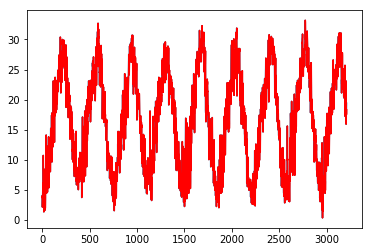



선형 모델



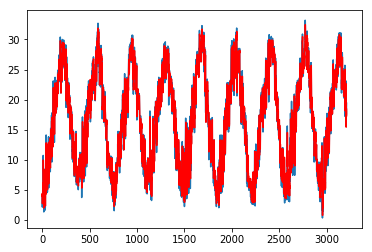



MLP 모델

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 100)               400       
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 101       
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
y_test.shapee = (3212,), y_pred.shape = (3212, 1)


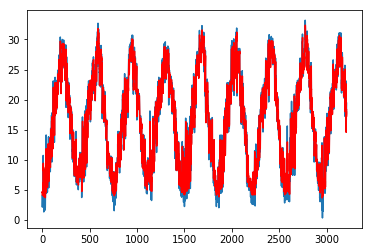



LSTM 모델

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


C:\Anaconda3\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


y_test.shapee = (3212,), y_pred.shape = (3212, 1)


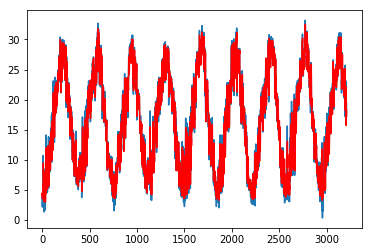



result_all = {'persistent_20_3_step': 2.059072352765388, 'linear_20_3_step': 1.9877056142487501, 'MLP_20_3_step': 1.9710177061287903, 'LSTM_20_3_step': 1.9790733308045572}
 n_steps = 7

퍼시스턴스 모델

x_train.shape = (4011, 7), y_train.shape = (4011,)


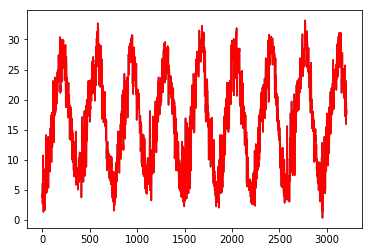



선형 모델



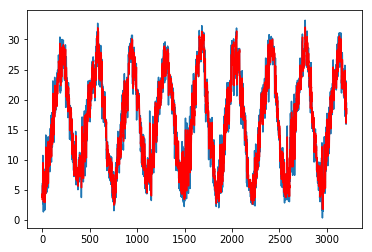



MLP 모델

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 100)               800       
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 101       
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________
y_test.shapee = (3208,), y_pred.shape = (3208, 1)


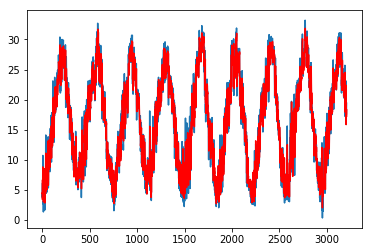



LSTM 모델

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


C:\Anaconda3\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


y_test.shapee = (3208,), y_pred.shape = (3208, 1)


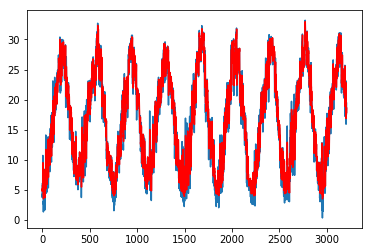



result_all = {'persistent_20_3_step': 2.059072352765388, 'linear_20_3_step': 1.9877056142487501, 'MLP_20_3_step': 1.9710177061287903, 'LSTM_20_3_step': 1.9790733308045572, 'persistent_20_7_step': 2.0601294659459763, 'linear_20_7_step': 1.9390888718803616, 'MLP_20_7_step': 1.885833373653711, 'LSTM_20_7_step': 1.9271361313341875}
 n_steps = 14

퍼시스턴스 모델

x_train.shape = (4004, 14), y_train.shape = (4004,)


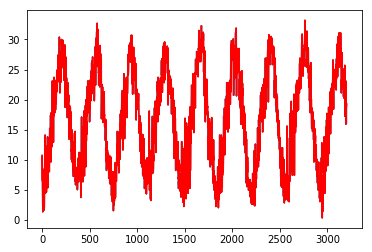



선형 모델



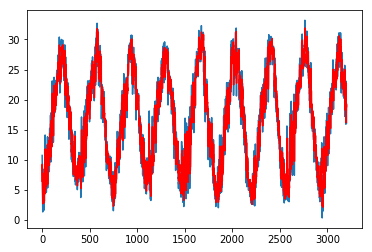



MLP 모델

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 100)               1500      
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 101       
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________
y_test.shapee = (3203,), y_pred.shape = (3203, 1)


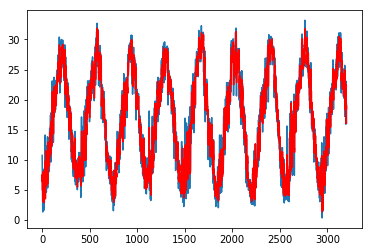



LSTM 모델

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


C:\Anaconda3\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


y_test.shapee = (3203,), y_pred.shape = (3203, 1)


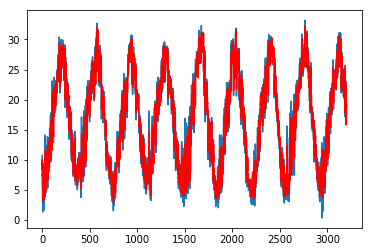



result_all = {'persistent_20_3_step': 2.059072352765388, 'linear_20_3_step': 1.9877056142487501, 'MLP_20_3_step': 1.9710177061287903, 'LSTM_20_3_step': 1.9790733308045572, 'persistent_20_7_step': 2.0601294659459763, 'linear_20_7_step': 1.9390888718803616, 'MLP_20_7_step': 1.885833373653711, 'LSTM_20_7_step': 1.9271361313341875, 'persistent_20_14_step': 2.0610999491320667, 'linear_20_14_step': 1.928041118016573, 'MLP_20_14_step': 1.8059016892320152, 'LSTM_20_14_step': 1.893387401293432}


In [87]:
####################################################
n_steps_range = [3,7,14]
noise = False

result_all = dict()
xs_o = year_data
ys_o = temp_data

for n_steps in n_steps_range:
    print(f" n_steps = {n_steps}\n")
    f_all(xs_o,ys_o,n_steps)

df_temp_next= pd.DataFrame(result_all, index=['df_temp'])   


 ,n_steps = 7

퍼시스턴스 모델

x_train.shape = (573, 7), y_train.shape = (573,)


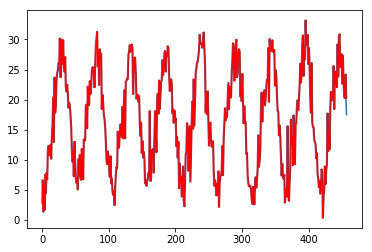



선형 모델



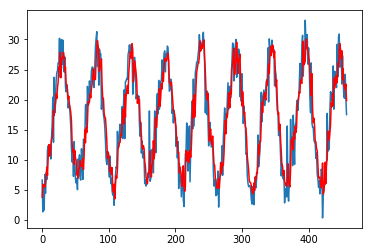



MLP 모델

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 100)               800       
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 101       
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________
y_test.shapee = (458,), y_pred.shape = (458, 1)


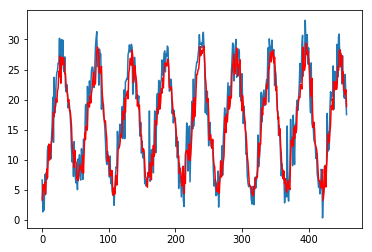



LSTM 모델

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


C:\Anaconda3\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


y_test.shapee = (458,), y_pred.shape = (458, 1)


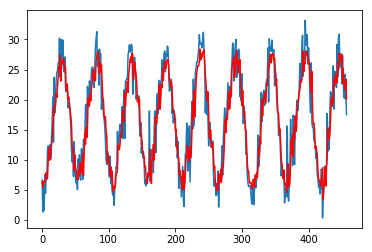



result_all = {'persistent_20_7_step': 3.690383466660933, 'linear_20_7_step': 3.1779469510767147, 'MLP_20_7_step': 3.1028433938194477, 'LSTM_20_7_step': 3.1164737051512468}


In [89]:
####################################################
n_steps = 7


result_all = dict()
xs_o = year_data
ys_o = temp_data


print(f" ,n_steps = {n_steps}\n")
f_all_nstep(xs_o,ys_o,n_steps)

df_temp_step7= pd.DataFrame(result_all, index=['df_temp'])   



In [95]:
df_temp_next.T

,df_temp
persistent_20_3_step,2.059072
linear_20_3_step,1.987706
MLP_20_3_step,1.971018
LSTM_20_3_step,1.979073
persistent_20_7_step,2.060129
linear_20_7_step,1.939089
MLP_20_7_step,1.885833
LSTM_20_7_step,1.927136
persistent_20_14_step,2.061100
linear_20_14_step,1.928041


In [99]:
df_temp_step7.T

,df_temp
persistent_20_7_step,3.690383
linear_20_7_step,3.177947
MLP_20_7_step,3.102843
LSTM_20_7_step,3.116474


In [148]:
#데이터 예측하기
result_all = dict()

def f_all_in_out_nstep(xs_o, ys_o,in_step,n_steps) :
    
    xx_o,yy_o = 0, 0
    
    X, y = split_sequence_instep_next_window(ys_o,in_step , n_steps)

    split = int (len(y) * 0.8)
    x_train_o = X
    x_test_o = X[:split]
    y_train_o = y
    y_test_o = y[:split]
    

    f_persisitence(xx_o,yy_o,xs_o, x_train_o, y_train_o, x_test_o, y_test_o,result_all, n_steps, split)
    f_linear( xx_o ,yy_o,xs_o, x_train_o, y_train_o, x_test_o, y_test_o, result_all, n_steps, split)
    f_mlp( xx_o ,yy_o,xs_o, x_train_o, y_train_o, x_test_o, y_test_o, result_all, in_step, split)
    f_lstm( xx_o ,yy_o,xs_o, x_train_o, y_train_o, x_test_o, y_test_o, result_all, in_step, split)
   
    print(f"result_all = {result_all}")
    return



 in_steps = 20 ,out_steps = 7

퍼시스턴스 모델

x_train.shape = (3992, 20), y_train.shape = (3992,)


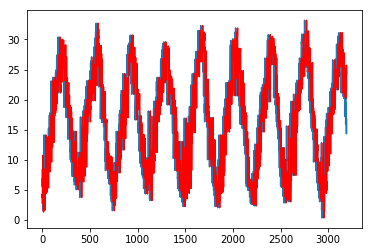



선형 모델



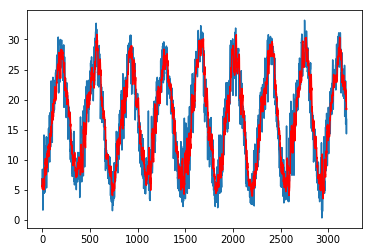



MLP 모델

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 100)               2100      
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 101       
Total params: 2,201
Trainable params: 2,201
Non-trainable params: 0
_________________________________________________________________
x_train.shape = (3992, 20), y_train.shape = (3992,)
x_test.shape = (3193, 20), y_train.shape = (3992,)
y_test.shape = (3193,), y_pred.shape = (3193, 1)


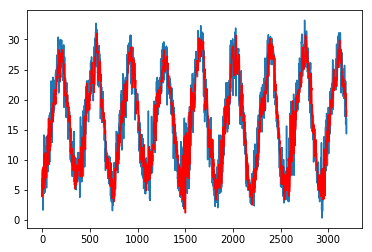



LSTM 모델

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


C:\Anaconda3\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


y_test.shapee = (3193,), y_pred.shape = (3193, 1)


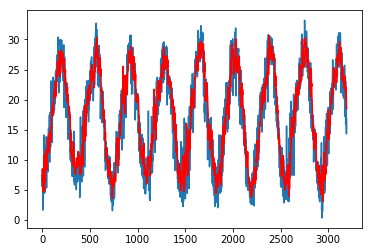



result_all = {'persistent_7_step': 4.314212958138236, 'linear_20_7_step': 2.9760013612454284, 'MLP_20_20_step': 2.6977357979610455, 'LSTM_20_20_step': 2.7485781523477493}


,persistent_7_step,linear_20_7_step,MLP_20_20_step,LSTM_20_20_step
LMSE,4.314213,2.976001,2.697736,2.748578


In [160]:
####################################################
in_steps = 20
out_steps = 7


xs_o = year_data
ys_o = temp_data


print(f" in_steps = {in_steps} ,out_steps = {out_steps}\n")
f_all_in_out_nstep(xs_o,ys_o,in_steps, out_steps)

df_temp_in_step= pd.DataFrame(result_all, index=['LMSE'])   
display(df_temp_in_step)